# Exercise: Estimating Elephants

Elephants, at birth, are about 1m long measured along their backs,
and grow about 10cm/year for the first 20 years,
although elephants of the same age differ by 10-20% or so
(see [Trimble et al](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0026614)).
Their rate of growth is also affected
by health (e.g., food availability and parasite load).
How well can we estimate the age of juvenile elephants (between 10-20 years old)
based on their lengths in aerial photographs?
Does it help much to take into account food availability?

To see how well we expect this to work, let's simulate some data.

In [5]:
import numpy as np
import matplotlib.pyplot as plt
rng = np.random.default_rng()

In [8]:
n = 100
age = rng.uniform(low=10, high=20, size=n) # in years
mean_length = 1 + .1 * age  # in m
length = rng.normal(loc=mean_length, scale=0.25, size=n)

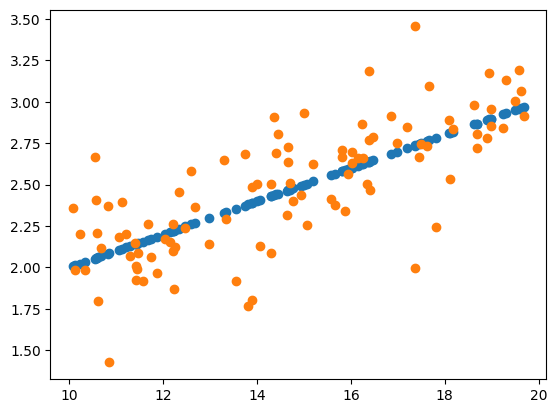

In [9]:
plt.scatter(age, mean_length)
plt.scatter(age, length);

What about food availability?
Let's measure food availability as a percentage
of 'optimal',
and suppose that for each 10% that food drops from this point,
average elephant size goes down by .15 * .25 m, on average
(15% of a standard deviation).
